F_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*Florian Burkhardt/Franz Ruppert* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 1

## Introduction

In this coding lab you get to implement a pipeline for spike detection and feature extraction, as presented in the lecture:
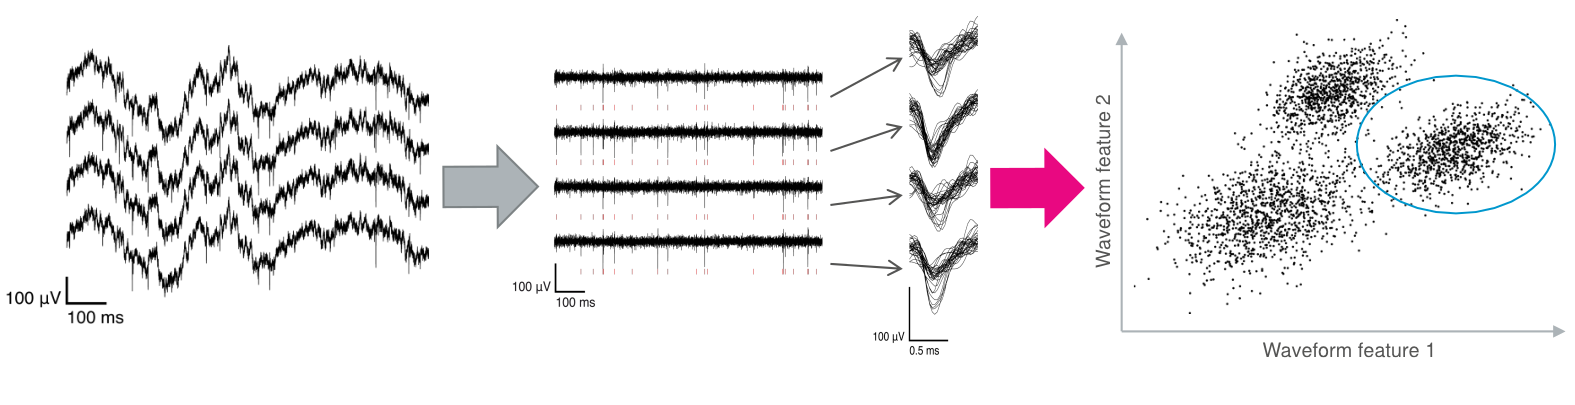

This will later be used for spike sorting (identifying which spike / waveform in the signal was caused by which neuron).

The data used in this notebook was recorded at 30kHz with a tetrode and thus contains the voltage traces of the 4 channels in μV.

_(for more information on the data acquisition, you can have a look at [Ecker et al 2014](https://doi.org/10.1016/j.neuron.2014.02.006), in particular the supplementary material. A similar pipeline is also used in [Ecker et al 2010](https://doi.org/10.1126/science.1179867). Note however that we only use a small portion of the data in this notebook and most of the experiment setup is not relevant here!)_

## Setup
- __Data__: Download the data file ```nds_cl_1.csv``` from ILIAS and save it in a subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.


Recommended folder structure:

```
.
├── data/
│   └── nds_cl_1.csv
├── notebooks
│   └── CodingLab1.ipynb
├── matplotlib_style.txt
└── requirements.txt
```

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import PCA
from __future__ import annotations  # for Python 3.8 and below

# black is a code formatter (see https://github.com/psf/black).
# It will automatically format the code you write in the cells imposing consistent Python style.
%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-04-27 21:27:45Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.35.0

sklearn: 1.6.1

sklearn   : 1.6.1
scipy     : 1.15.2
matplotlib: 3.10.1
numpy     : 2.2.5
pandas    : 2.2.3

Watermark: 2.5.0



In [22]:
# matplotlib style file
# Template for style file: https://matplotlib.org/stable/tutorials/introductory/customizing.html#customizing-with-style-sheets
plt.style.use("../matplotlib_style.txt")

## Load data

In [23]:
fs = 30000.0  # sampling rate of the signal in Hz
dt = 1 / fs
cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
x = pd.read_csv("../data/nds_cl_1.csv", header=0, names=cols)

In [24]:
x.describe()

,Ch1,Ch2,Ch3,Ch4
count,1.920000e+07,1.920000e+07,1.920000e+07,1.920000e+07
mean,3.600331e+00,-8.850918e-01,2.864284e-01,2.210982e+00
std,5.824474e+02,6.014818e+02,6.464363e+02,6.126105e+02
min,-3.607000e+03,-3.739000e+03,-3.871000e+03,-3.750000e+03
25%,-3.460000e+02,-3.610000e+02,-3.950000e+02,-3.640000e+02
50%,1.200000e+01,8.000000e+00,-1.000000e+00,1.000000e+01
75%,3.650000e+02,3.720000e+02,4.010000e+02,3.810000e+02
max,2.873000e+03,3.004000e+03,3.099000e+03,3.017000e+03


## Task 1: Filter Signal

In order to detect action potentials, the first step is to filter out low frequency fluctuations (LFP) and high frequency noise. Determine appropriate filter settings and implement the filtering in the function ```filter_signal()```. A typical choice for this task would be a <mark>butterworth filter</mark>.

Plot a segment of the raw signal and the filtered signal for all four channels with matching y-axis. The segment you choose should contain spikes. When you apply the function also test different filter settings.

*Grading: 3 pts*


In [25]:
from scipy.signal import butter, filtfilt

## Current Best Practice


def filter_signal(
    x: pd.DataFrame, fs: float, low: float, high: float, order: int = 3
) -> pd.DataFrame:
    """Filter raw signal x.

    Parameters
    ----------

    x: pd.DataFrame, (n_samples, n_channels)
        Each column in x is one recording channel.

    fs: float
        Sampling frequency.

    low, high: float, float
        Passband in Hz for the butterworth filter.

    order: int
        The order of the Butterworth filter. Default is 3, but you should try
        changing this and see how it affects the results.


    Returns
    -------

    y: pd.DataFrame, (n_samples, n_channels)
        The filtered x. The filter delay is compensated in the output y.


    Notes
    ----

    1. Try exploring different filters and filter settings. More info:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

    2. The output signal should be phase-shift compensated. More info:
    https://dsp.stackexchange.com/a/19086

    """
    # 1) Compute Nyquist and normalize cutoff frequencies
    nyq = fs / 2.0
    low_norm = low / nyq
    high_norm = high / nyq

    # 2) Design band‑pass Butterworth filter
    b, a = butter(order, [low_norm, high_norm], btype="band")

    # 3) Apply zero‑phase filtering
    #    axis=0 runs along rows (samples), filtering each column
    filtered_vals = filtfilt(b, a, x.values, axis=0)

    # 4) Return as DataFrame with same index/columns
    return pd.DataFrame(filtered_vals, index=x.index, columns=x.columns)

In [26]:
xf = filter_signal(x, fs, 500, 4000)

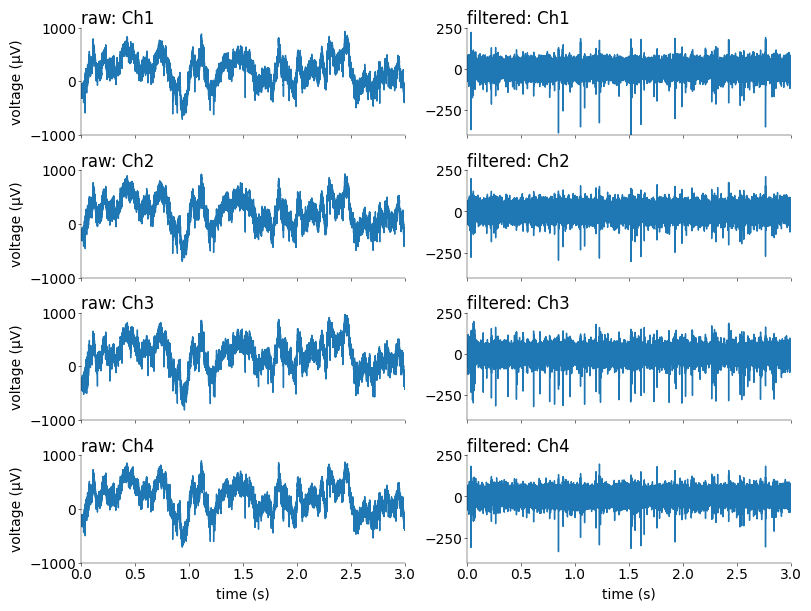

In [27]:
mosaic = [
    ["raw: Ch1", "filtered: Ch1"],
    ["raw: Ch2", "filtered: Ch2"],
    ["raw: Ch3", "filtered: Ch3"],
    ["raw: Ch4", "filtered: Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

# ------------------------------------------------------------------------------------
# Plot raw and filtered signals for all 4 channels and answer the questions (1+1 pts)
# ------------------------------------------------------------------------------------

T = 100000
t = np.arange(0, T) * dt

for i, (raw, filtered) in enumerate(mosaic):
    ch = raw.split(": ")[1]

    ax[raw].plot(t, x[ch].values[:T])
    ax[filtered].plot(t, xf[ch].values[:T])

    ax[raw].set_xlim((0, 3))
    ax[raw].set_ylim((-1000, 1000))

    ax[filtered].set_xlim((0, 3))
    ax[filtered].set_ylim((-400, 250))

    # Add labels and title
    ax[raw].set_ylabel("voltage (μV)")
    ax[raw].set_title(raw, loc="left")
    ax[filtered].set_title(filtered, loc="left")
    if i != 3:
        ax[raw].set_xticklabels([])
        ax[filtered].set_xticklabels([])
    else:
        ax[raw].set_xlabel("time (s)")
        ax[filtered].set_xlabel("time (s)")

plt.show()

### Questions
1) Explain your implementation: Which filter and parameters did you choose and why?s

We apply a 3rd-order Butterworth band-pass filter from 500 Hz to 4 kHz, implemented via SciPy’s butter and zero-phase forward-backward filtering (filtfilt). The Butterworth design gives a maximally-flat passband, so spike energy isn’t distorted by ripples. By choosing 500 Hz–4 kHz, we capture the bulk of action-potential spectral energy while removing slow LFP drift and high-frequency noise . Choosing 3rd-order for the filter gives a moderate slope that’s steep enough to attenuate unwanted frequencies but not so steep as to introduce excessive ringing or demand huge filter coefficients. Higher orders could marginally tighten the band but at the cost of increased phase distortion (if used with a single-pass filter) and numerical instability. By filtering forward and backward we cancel out phase shifts entirely, ensuring spike waveforms aren’t time-shifted or skewed.

2) Which parameters of the function can be adjusted, which are determined by the experiment setup? What is the effect of the adjustable parameters?

Adjustable filter parameters:
- low, high (Hz), define the band-pass window; raising "low" removes more slow drift but risks cutting spike onset; lowering "high" suppresses more high-frequency noise but can reduce spike high-frequency content.
- filter type & mode: choosing between Butterworth and other filter types, and between causal (lfilter) or zero-phase (filtfilt), changes phase response and roll-off behavior.
- order (integer), Controls the steepness of the filter’s roll-off, Higher order → sharper cutoff and better stop-band attenuation, at the cost of increased ringing and longer filter “memory.”, Lower order → gentler slope with less transient distortion, but more leakage of unwanted frequencies into the passband

Parameters set by experimental setup:
- fs (sampling frequency), determined by recording hardware (e.g. 30 kHz on Neuropixels), fixes the Nyquist frequency (fs/2) and therefore the normalization of your cutoffs
- Input data x: the raw voltage traces themselves

3) How does the filtered signal look compared to the original? Why is this helpful as preprocessing in our spike detection pipeline?

After filtering, slow oscillations (LFP) are largely gone, and high-frequency jitter is attenuated such that spike waveforms stand out clearly against a flat baseline. This improves signal-to-noise ratio, making threshold-based detection more reliable and making sure that threshold crossings more likely reflect true neural events rather than slow drift or high-frequency artifact. And since we used zero-phase filtering, the measured spike timing, the onset and peak of each spike remain correctly aligned. 


## Task 2: Detect action potentials

Action potentials are usually detected by finding large-amplitude deflections in the continuous signal. A good choice of threshold for detecting spikes is important. If it is too low, you will detect too many low amplitude events (noise); if it is too high, you run the risk of missing good spikes. Implement an automatic procedure to obtain a reasonable threshold and detect the times when spikes occurred in the function ```detect_spikes()```.

Plot a segment of the filtered signal for all four channels with matching y-axis and indicate the time points where you detected spikes, also **plot the threshold**.

*Grading: 4 pts*

In [28]:
from scipy.signal import find_peaks


def detect_spikes(
    x: np.ndarray, fs: float, N: int = 5, lockout: float = 1.0
) -> tuple[np.ndarray, np.ndarray, np.float64]:
    """Detect spikes in the signal x and compute a threshold.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal from Task 1.

    fs: float
        the sampling rate (in Hz).

    N: int
        An arbitrary number with which you multiply with the standard deviation
        to set a threshold that controls your false positive rate. Default is 5
        but you should try changing it and see how it affects the results.

    lockout: float
        a window of 'refractory period', within which there's only one spike.
        Default is 1ms but you should also try changing it.


    Returns
    -------

    s: np.array, (n_spikes, )
        Spike location / index in the signal x.

    t: np.array, (n_spikes, )
        Spike time in ms. By convention the time of the zeroth sample is 0 ms.

    thrd: float
        Threshold = -N * sigma.


    Tips
    ----

    You can use scipy functions like find_peaks for the detection.
    Note: There are four channels in signal x.

    """
    # --------------------------------------------------------------
    # compute the robust s.d. and calculate the threshold (0.5 pts)
    # --------------------------------------------------------------
    # estimate standard deviation of signal
    av = np.mean(x)
    mad = np.median(np.abs(x - av))
    sigma = mad / 0.6745

    thr = np.float64(N * sigma)  # positive as we invert the signal later

    # --------------------------
    # find all spikes (1.5 pts)
    # --------------------------

    refractory = int((lockout * fs) / 1000)  # transform lockout time to frames

    min_chan = np.min(x, axis=1)
    # only keep the biggest amplitude over all channels (i.e. the most negative value) so we always get the biggest spike (which would be a negative deviation in the signal)
    # Otherwise, if the spikes are slightly shifted you get multiple spikes in the refractory period

    s, _ = find_peaks(-min_chan, height=thr, distance=refractory)
    # find peaks in the signal exceeding threshold
    # invert as find_peaks tracks local maxima

    t = s.astype(float) / fs * 1000.0  # convert spike times to ms

    return s, t, thr

In [29]:
xf_arr = xf.to_numpy()  # shape (n_samples, 4); convert into np array
s, t, thr = detect_spikes(xf, fs)

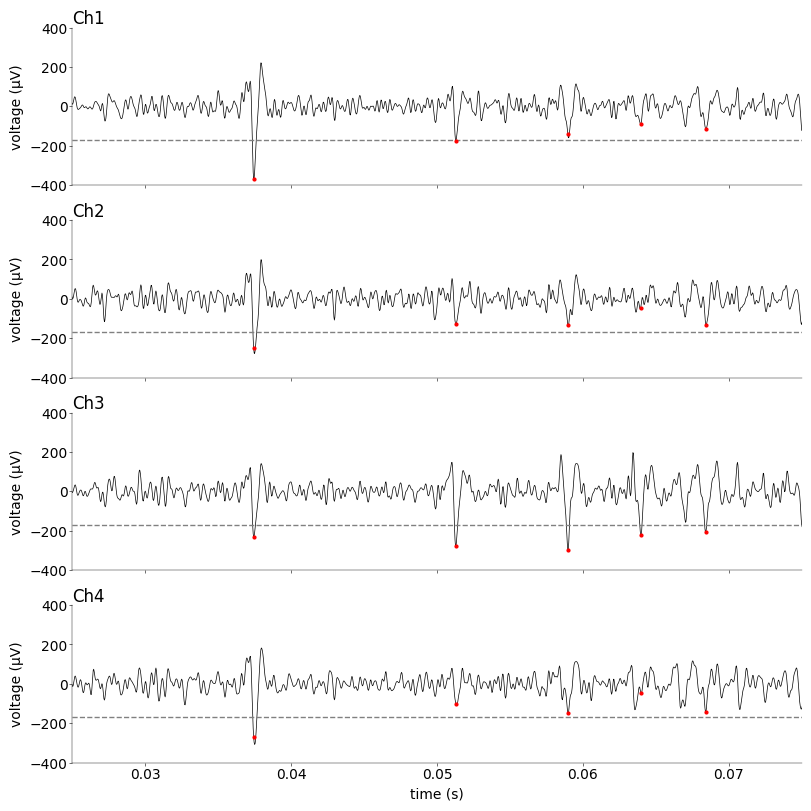

In [30]:
mosaic = [
    ["Ch1"],
    ["Ch2"],
    ["Ch3"],
    ["Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100
)
time = np.arange(xf_arr.shape[0]) / fs

# ------------------------------------------------------------------------------
# plot signal, threshold and detected spikes and answer the questions (1+1 pts)
# ------------------------------------------------------------------------------

for i, col in enumerate(cols):

    ax[col].set_ylim((-400, 400))
    ax[col].set_xlim((0.025, 0.075))
    ax[col].set_ylabel("voltage (μV)")

    ax[col].set_title(col, loc="left")

    if col != "Ch4":
        ax[col].set_xticklabels([])
    else:
        ax[col].set_xlabel("time (s)")

    # Plot filtered signal
    ax[col].plot(time, xf_arr[:, i], color="black", linewidth=0.5)

    # Plot thresholds
    ax[col].hlines(
        -thr, xmin=0.025, xmax=0.075, colors="gray", linestyles="--", linewidth=1
    )

    # Plot detected spikes in this window
    mask_win = (s >= 0.025 * fs) & (s <= 0.075 * fs)
    idx_win = s[mask_win]
    ax[col].plot(idx_win / fs, xf_arr[idx_win, i], "r.", markersize=4)

plt.show()

### Questions

1) Are the detected time points well aligned with prominent extrema in the signal? Also compare your detections across channels.

Wee see the detected time points of the largest amplitude over all channels. Thus the timepoints are mostly well alligned over all channels but sometimes shifted by a few frames. This could be due to the spatial layout of the tetrode electrodes. 

2) Take one feature of the spikes and explain how that can help us identifying the source neuron of a spike (only based on visual examination of the plot).

Looking at the total approximated Energy of the spikes we can try to identify the source neuron. For example, looking at the first spike in the plot, it could be in both neurons, but the energy is slighty larger in channels 1 and 4. The second spike hast the by far highest Energy in channel 3 so it could be a spike in a neuron close to the third tetrode channel

## Task 3: Extract waveforms
For later spike sorting we need the waveforms of all detected spikes. Extract the waveforms segments (1 ms) on all four channels for each spike time (as a result each spike is represented by a 4x30 element matrix). Implement this procedure in the function ```extract_waveforms()```.

Plot (a) the first 100 spikes you detected and (b) the 100 largest spikes you detected.
Are there a lot of very small spikes (likely noise) among your detected spikes? If so your threshold may be too low. Can you see obvious artifacts, not looking like spikes at all?

*Grading: 3 pts*

In [31]:
def extract_waveforms(x: np.ndarray, s: np.ndarray) -> np.ndarray:
    """Extract spike waveforms at times s (given in samples)
    from the filtered signal `xf` using a fixed window around the
    times of the spikes.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal.

    s: np.array, (n_spikes, )
        Spike time in samples.


    Return
    ------

    w: np.array, (n_spikes, length_window, n_channels)
        Waveforms. (You don't have to get the exact same
        shape as we noted here. It's just the shape of w
        that can be easily retrieved via broadcasting.)


    Notes
    -----

    More on Numpy Broadcasting
    https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html

    """
    # -------------------------------
    # extract spike waveforms (1 pt)
    # -------------------------------
    # create window of number of samples
    # 1 ms window → number of samples
    window_len = int(0.001 * fs)  # e.g. 0.001 * 30000 ≃ 30
    pre = (
        window_len // 2
    )  # approx first half of samples inside window; i.e approx first half of the spike
    post = (
        window_len - pre
    )  # remainder of samples inside window ; i.e. approx second half of the spike

    n_samples, n_ch = x.shape

    # drop any spike within 'pre' samples of start or 'post' of end
    valid = (s >= pre) & (s + post <= n_samples)
    s_valid = s[valid]

    # allocate output: (#spikes, window_len, #channels)
    w = np.zeros((len(s_valid), window_len, n_ch))

    # extract each window
    for i, spike in enumerate(s_valid):
        start = spike - pre
        end = spike + post
        w[i] = x[start:end, :]

    return w

In [32]:
waves = extract_waveforms(xf_arr, s)  # extract spike waveforms from filtered signal

Plot first 100 spike waveforms

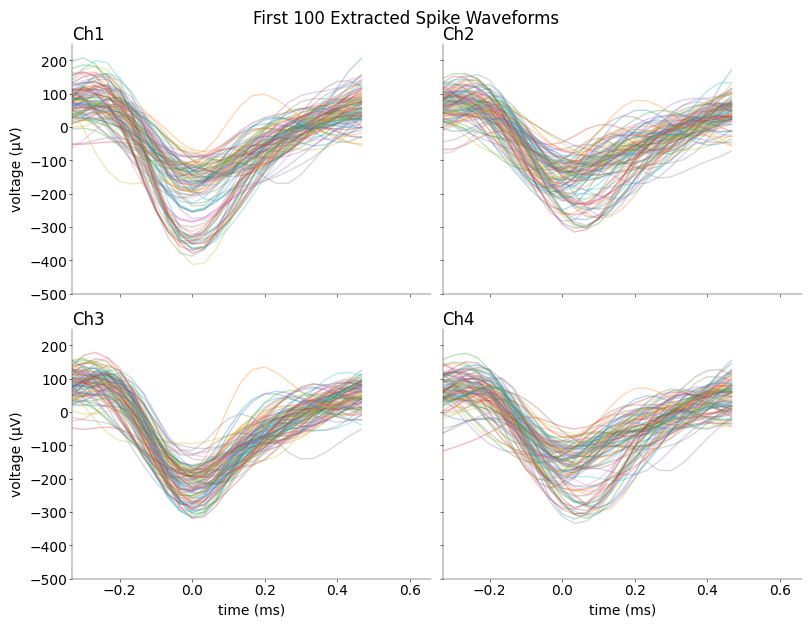

In [33]:
# Time axis for each snippet, centered on the spike (in ms)
window_len = waves.shape[1]
t_w = (np.arange(window_len) - window_len // 2) / fs * 1e3

# ---------------------------------------------------------------------
# plot first and largest 100 spikes and answer the questions (1+1 pts)
# ---------------------------------------------------------------------

# first 100 spikes

# First 100 spikes
first100 = waves[:100]  # select first 100 waves of each channel

mosaic = [
    ["Ch1", "Ch2"],
    ["Ch3", "Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
for i, col in enumerate(cols):

    # labeling etc
    ax[col].set_ylim((-500, 250))
    ax[col].set_xlim((-0.33, 0.66))
    ax[col].set_title(col, loc="left")
    if col == "Ch3" or col == "Ch4":
        ax[col].set_xlabel("time (ms)")
    else:
        ax[col].set_xticklabels([])
    if col == "Ch1" or col == "Ch3":
        ax[col].set_ylabel("voltage (μV)")
    else:
        ax[col].set_yticklabels([])

    # plot first waveforms per channel i
    for wf in first100[:, :, i]:
        ax[col].plot(t_w, wf, alpha=0.3)

fig.suptitle("First 100 Extracted Spike Waveforms", y=1.02)
plt.show()

Plot largest 100 spike waveforms

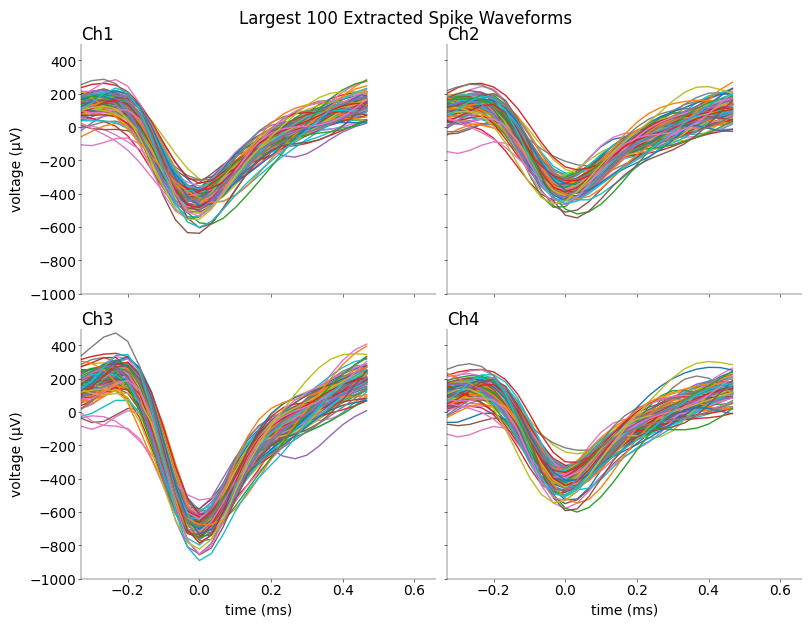

In [34]:
# largest 100 spikes

# Peak-to-peak size per spike (across all channels & samples)
ptp = waves.max(axis=(1, 2)) - waves.min(axis=(1, 2))
largest100 = waves[
    np.argsort(ptp)[-100:]
]  # select largest 100 waveforms of each channel

fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

for i, col in enumerate(cols):

    # labeling etc
    ax[col].set_ylim((-1000, 500))
    ax[col].set_xlim((-0.33, 0.66))
    ax[col].set_title(col, loc="left")
    if col == "Ch3" or col == "Ch4":
        ax[col].set_xlabel("time (ms)")
    else:
        ax[col].set_xticklabels([])
    if col == "Ch1" or col == "Ch3":
        ax[col].set_ylabel("voltage (μV)")
    else:
        ax[col].set_yticklabels([])

    # plot largest waveform per channel i
    for wf in largest100[:, :, i]:
        ax[col].plot(t_w, wf)

fig.suptitle("Largest 100 Extracted Spike Waveforms", y=1.02)
plt.show()

### Questions

1) Describe the shape of the spikes.

Looking at the largest spikes we see a small positive deflection followed by a large negative amplitude (the extracellular "spike"). After the spike we observe a slow regression to the baseline voltage. This is slightly surprising as we would expect a slight overshoot in the positive direction as a representation of the refractory period after a spike. 
In the first 100 spikes, we see similar patterns however we observe a lot more deviation.

2) Do the waveforms tend to be similar? If spikes have a similar waveform, what could that mean - and what does it mean if the waveforms look different?

For the largest spikes the waveforms tend to be very similar. This should mean that we really see spikes here that are from neurons closest to the particular channel. In the first 100 spikes the waveforms are not equally as similar which could either mean that we observe the channels picking up slight shifts or some spikes from further away, or that we include some noise as spikes. 

## Task 4: Extract features using PCA
Compute the first three PCA features on each channel separately in ```extract_features()```. You can use a available PCA implementation or implement it yourself. After that, each spike is represented by a 12 element vector. Compute the fraction of variance captured by these three PCs. Also return the obtained parameters of the PCA

For one channel, plot the mean and the first three principal axes as calculated by the PCA in the feature space. Interprete them in light of the plots in the previous tasks.

For all pairwise combinations of channels, plot the resulting features of the 1st PCs as scatter plots against each other. Do you see clusters visually?

*Grading: 6 pts*

## PCA
### Questions (1 pt)
1) If we input the data from each channel separately to a PCA, what are the feature dimension of the input?

_YOUR ANSWER HERE_

2) Therefore, what do the Principal Axes the PCA computes represent?

_YOUR ANSWER HERE_

3) Does it make sense to apply preprocessing steps, such as normalization? Have a look at the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). What is applied by default?

_YOUR ANSWER HERE_
right now the raw PC scores may have wildly different scales across channels. You might consider StandardScaler() or simply dividing each component by its explained‐variance before hstacking.

In [35]:
"""Solution"""


def extract_features(w: np.ndarray) -> np.ndarray:
    """Extract features for spike sorting from the waveforms w.

    Do PCA on the waveforms of each channel separately,
    then concatenate the first three principal components
    of each channels into one numpy array (`b`).


    Parameter
    ---------

    w: np.ndarray, (n_spikes, length_window, n_channels)
        Waveforms from Task 3.


    Return
    ------

    b: np.ndarray, (n_spikes, n_feature)
        the transformed data
    means: np.ndarray, (n_channels, length_window)
        means per channel
    principal_components: np.ndarray, (n_channels, 3, length_window)
        the 'principal axes' obtained by the pca


    Notes
    -----

    You can use PCA from sklearn.

    More on PCA
    https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

    """

    # ----------------------------------------------
    # obtain first 3 principle components (1.5 pts)
    # ----------------------------------------------

    # -----------------------------------------------------------------------------------------------------
    # Print the fraction of variance explained by the three components combined for each channel (0.5 pts)
    # -----------------------------------------------------------------------------------------------------

    n_spikes, window_len, n_ch = w.shape

    # containers
    features = []  # list to collect (n_spikes x 3) per channel
    means = np.zeros((n_ch, window_len))
    pcs = np.zeros((n_ch, 3, window_len))

    # Loop over channels
    for c in range(n_ch):
        data = w[:, :, c]  # select data from single channel
        pca = PCA(n_components=3)  # three principal components
        transformed = pca.fit_transform(data)  # fit PCA to data (n_spikes, 3)

        # Store results
        features.append(transformed)
        means[c] = pca.mean_
        pcs[c] = pca.components_

        # Print variance explained per channel
        var_explained = (
            pca.explained_variance_ratio_.sum()
        )  # sum up explained variance of three principal components
        print(
            f"Channel {c+1}: {var_explained*100:.2f}% variance captured by first 3 PCs"
        )

    # Concatenate features from all channels
    b = np.hstack(features)  # (n_spikes, 3 * n_ch)

    return b, means, pcs

In [36]:
b, means, pcs = extract_features(waves)

Channel 1: 82.20% variance captured by first 3 PCs
Channel 2: 75.37% variance captured by first 3 PCs
Channel 3: 80.11% variance captured by first 3 PCs
Channel 4: 77.22% variance captured by first 3 PCs


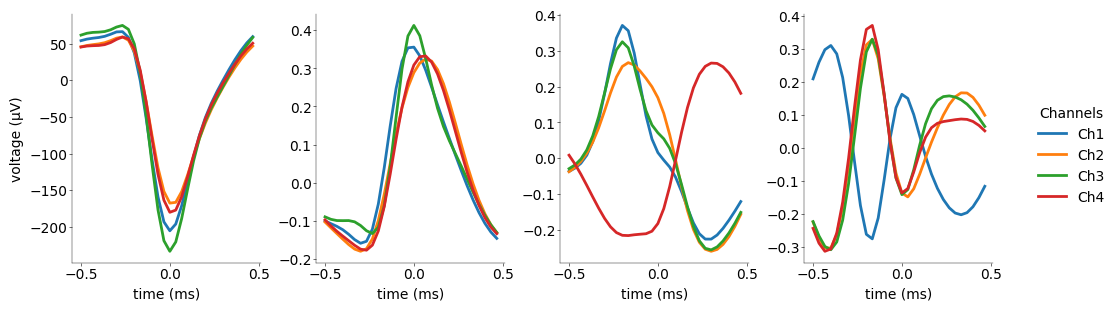

In [37]:
"""Solution"""

# ------------------------------------------------------------------------------------------------------------------
# Plot the mean of each channel and the three principal axes obtained by the PCA and answer the questions (1+1 pts)
# ------------------------------------------------------------------------------------------------------------------

# build time axis for 1 ms window, centered at 0
window_len = means.shape[1]
t_w = (np.arange(window_len) - window_len // 2) / fs * 1e3  # in ms
n_ch = waves.shape[2]

mosaic = [
    ["mean", "Principal Axes 1", "Principal Axes 2", "Principal Axes 3"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(10, 3), layout="constrained", dpi=100
)

# choose a distinct color for each channel
colors = plt.cm.tab10(np.arange(n_ch))

# plot all channels' means and PCs
for c in range(n_ch):
    label = f"Ch{c+1}"
    color = colors[c]
    ax["mean"].plot(t_w, means[c], lw=2, color=color, label=label)
    ax["Principal Axes 1"].plot(t_w, pcs[c, 0], lw=2, color=color)
    ax["Principal Axes 2"].plot(t_w, pcs[c, 1], lw=2, color=color)
    ax["Principal Axes 3"].plot(t_w, pcs[c, 2], lw=2, color=color)

# axis labels
ax["mean"].set_ylabel("voltage (μV)")
for key in mosaic[0]:
    ax[key].set_xlabel("time (ms)")

# create a single legend to the right of all subplots
handles, labels = ax["mean"].get_legend_handles_labels()
fig.legend(
    handles, labels, bbox_to_anchor=(1.02, 0.5), loc="center left", title="Channels"
)


plt.show()

### Questions

1) Compare the plot to the plots of the other tasks. What do you observe?

_YOUR ANSWER HERE_

2) What does the mean look like? Does this match your expectations?

_YOUR ANSWER HERE_

3) Explain what it means if a spike has a high value in the first dimension. What is the effect of the other dimensions?

_YOUR ANSWER HERE_

Text(0.5, 0.98, 'Pairwise 1st PCs')

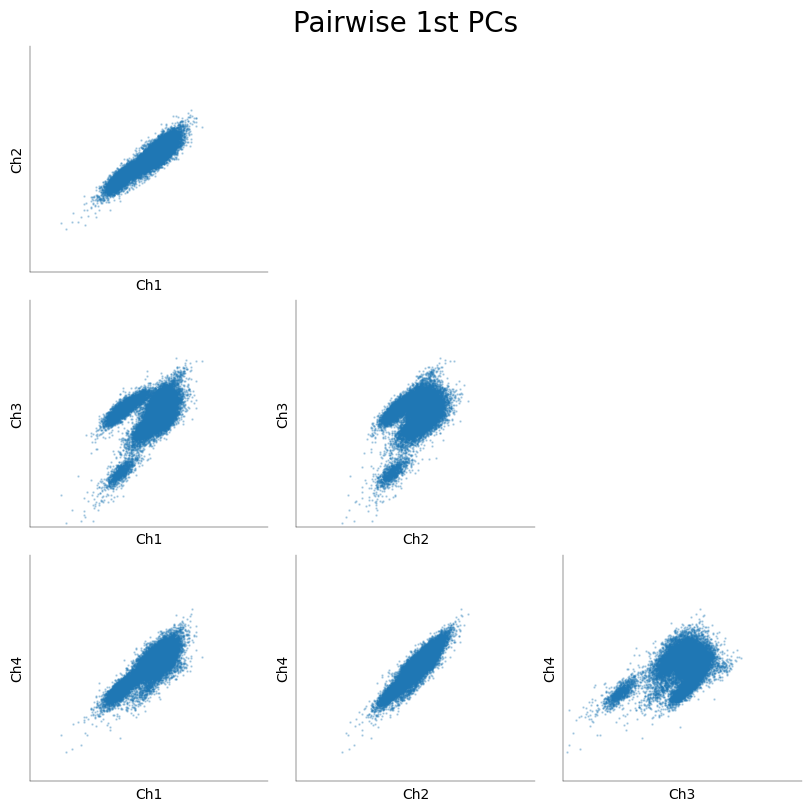

In [38]:
"""Solution"""

# ----------------------------------------------------------------------------------------------------------
# Create a scatterplot of the projections of the spikes for all pairwise combinations of the 1st PCs (1 pt)
# ----------------------------------------------------------------------------------------------------------

mosaic = [
    ["Ch2 vs Ch1", ".", "."],
    ["Ch3 vs Ch1", "Ch3 vs Ch2", "."],
    ["Ch4 vs Ch1", "Ch4 vs Ch2", "Ch4 vs Ch3"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100
)

# index of the 1st PC in `b`
i = {"Ch1": 0, "Ch2": 3, "Ch3": 6, "Ch4": 9}

for mo in np.ravel(mosaic):
    if mo == ".":
        continue
    y, x = mo.split(" vs ")

    # plot scatter of PC1 features: x-axis = channel x, y-axis = channel y
    ax[mo].scatter(
        b[:, i[x]],  # x-values
        b[:, i[y]],  # y-values
        s=2,  # point size
        alpha=0.3,  # transparency
    )

    ax[mo].set_xlabel(x)
    ax[mo].set_ylabel(y)
    ax[mo].set_xlim((-1500, 1500))
    ax[mo].set_ylim((-1500, 1500))
    ax[mo].set_xticks([])
    ax[mo].set_yticks([])

fig.suptitle("Pairwise 1st PCs", fontsize=20)

In [39]:
# save data for the next Coding Lab

# np.save("../data/nds_cl_1_features", b)
# np.save("../data/nds_cl_1_spiketimes_s", s)
# np.save("../data/nds_cl_1_spiketimes_t", t)
# np.save("../data/nds_cl_1_waveforms", w)